<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%A0%D0%B0%D1%81%D0%BA%D1%80%D0%B0%D1%88%D0%B8%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%87%D0%B5%D1%80%D0%BD%D0%BE_%D0%B1%D0%B5%D0%BB%D1%8B%D1%85_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_OpenCV_%D0%B8_%D0%B3%D0%BB%D1%83%D0%B1%D0%BE%D0%BA%D0%BE%D0%B3%D0%BE_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Раскрашивание черно-белых изображений с помощью OpenCV и глубокого обучения 

# Coloring black and white images with OpenCV and deep learning 

В этом уроке вы узнаете, как раскрашивать черно-белые изображения с помощью OpenCV, Deep Learning и Python.
Раскрашивание изображения - это процесс получения входного изображения в оттенках серого (черно-белого) и последующего создания выходного раскрашенного изображения , представляющего семантические цвета и тона входных данных (например, океан в ясный солнечный день должен быть правдоподобно «синим» - модель не может быть окрашена в «ярко-розовый»).
Подход, который мы собираемся использовать здесь сегодня, основан на глубоком обучении. Мы будем использовать сверточную нейронную сеть, способную раскрашивать черно-белые изображения с результатами, которые могут «обмануть» людей!
Сеть обучались на датасете ImageNet, а затем преобразовала все изображения из цветового пространства RGB в цветовое пространство Lab.


In this tutorial, you will learn how to colorize black and white images using OpenCV, Deep Learning, and Python.
Image coloring is the process of taking an input grayscale (black and white) image and then creating an output colored image that represents the semantic colors and tones of the input data (for example, an ocean on a clear sunny day should be plausibly "blue" - the model cannot be colored in "hot pink").
The approach we're going to use here today is deep learning. We'll be using a convolutional neural network capable of coloring black and white images with results that can "trick" people!
The network trained on the ImageNet dataset and then converted all images from RGB to Lab.






Подобно цветовому пространству RGB, цветовое пространство Lab имеет три канала. Но в отличие от цветового пространства RGB, Lab по-другому кодирует информацию о цвете:


Similar to the RGB color space, the Lab color space has three channels. But unlike the RGB color space, Lab encodes color information differently:




* L канала только кодирует интенсивность освещенности.  L channel only encodes light intensity.
* a канал кодирует зеленый-красный. a channel encodes green-red.
* b канал кодирует сине-желтый. b channel encodes blue-yellow


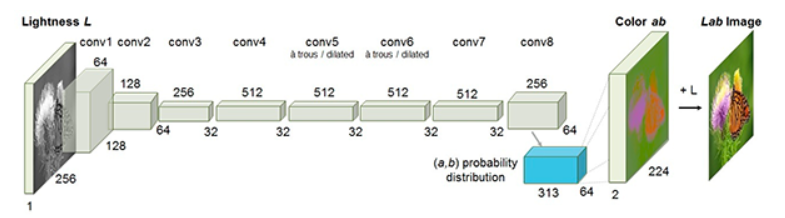

Рис. 1 - Архитектура сверточной сети.

Fig. 1 - Convolutional network architecture.

### Загрузка файлов  
### Download the code zip file

In [1]:
!wget http://dataudt.ru/datasets/cv/Lesson_12.Image_colorization.zip
!unzip -qq Lesson_12.Image_colorization.zip
%cd /content/Lesson_12.Image_colorization/

--2022-02-21 06:21:47--  http://dataudt.ru/datasets/cv/Lesson_12.Image_colorization.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131110019 (125M) [application/zip]
Saving to: ‘Lesson_12.Image_colorization.zip’

Lesson_12.Image_col 100%[===================>] 125.04M  16.6MB/s    in 8.3s    

2022-02-21 06:21:56 (15.1 MB/s) - ‘Lesson_12.Image_colorization.zip’ saved [131110019/131110019]

/content/Lesson_12.Image_colorization


### Импорт библиотек 
### Import Packages

In [2]:
# импортируем необходимые библиотеки
# import the necessary packages
from imutils.video import VideoStream
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2

### Функция отображения изображений в Jupyter Notebooks и Google Colab  
### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
    # конвертируем изображение из формата BGR в RGB и отображаем его 
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.figure(figsize=(10,10))
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Раскрашивание черно-белых изображений с помощью OpenCV 
### Colorizing black and white images with OpenCV

In [4]:


# явно укажем аргументы необходимые для работы
# image - путь к входному черно-белому изображению
# prototxt - путь к файлу Caffe prototxt
# model - путь к предварительно обученной модели
# points - путь к точке центра кластера

# explicitly specify the arguments needed to work
# image - path to input black and white image
# prototxt - path to Caffe prototxt file
# model - path to pre-trained model
# points - path to cluster center point
args = {
	"image": "images/monroe.jpg",
    "prototxt": "model/colorization_deploy_v2.prototxt",
    "model": "model/colorization_release_v2.caffemodel",
    "points": "model/pts_in_hull.npy"
}

In [5]:
# загружаем раскрашивающую черно-белые цвета модель и
# кластер центральных точек с диска
# load our serialized black and white colorizer model and cluster
# center points from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(args["prototxt"], args["model"])
pts = np.load(args["points"])

# добавляем в модель центры кластеровв качестве сверток 1x1
# add the cluster centers as 1x1 convolutions to the model
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

[INFO] loading model...


In [6]:
# загружаем входное изображение с диска, масштабируем яркость пикселей в
# диапазоне [0, 1], а затем преобразовываем изображение из BGR
# в цветовое пространство Lab
# load the input image from disk, scale the pixel intensities to the
# range [0, 1], and then convert the image from the BGR to Lab color
# space
image = cv2.imread(args["image"])
scaled = image.astype("float32") / 255.0
lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

In [7]:
# изменяем размер изображения Lab до 224x224 (сеть принимает
# размеры раскраски), разделяем каналы, извлекаем L-канал, а затем
# выполняем центрирование
# resize the Lab image to 224x224 (the dimensions the colorization
# network accepts), split channels, extract the 'L' channel, and then
# perform mean centering
resized = cv2.resize(lab, (224, 224))
L = cv2.split(resized)[0]
L -= 50

In [8]:
# пропускаем L-канал через сеть, который * предсказывает * значения 'a'
# и 'b' канала
# pass the L channel through the network which will *predict* the 'a'
# and 'b' channel values
'print("[INFO] colorizing image...")'
net.setInput(cv2.dnn.blobFromImage(L))
ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

# изменяем размер прогнозируемой величины 'ab' до той же размерности, что и наше
# входное изображение
# resize the predicted 'ab' volume to the same dimensions as our
# input image
ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

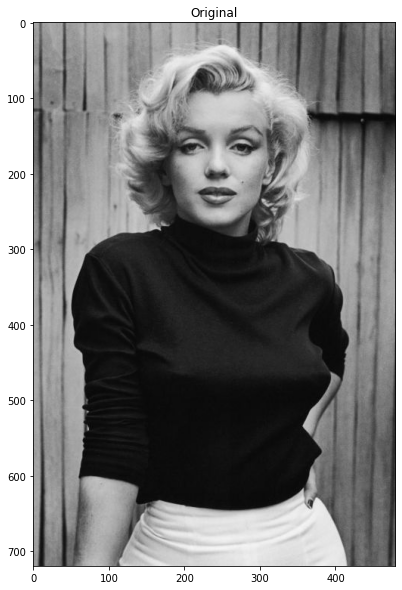

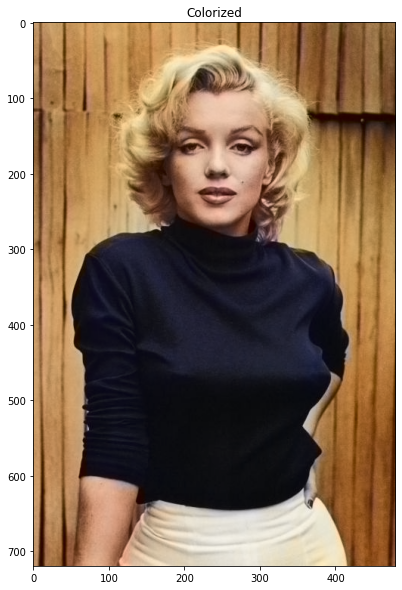

In [9]:
# берем канал 'L' из * исходного * входного изображения
# (с неизмененным размером) и объединяем его с
# прогнозируемым каналом 'ab'
# grab the 'L' channel from the *original* input image (not the
# resized one) and concatenate the original 'L' channel with the
# predicted 'ab' channels
L = cv2.split(lab)[0]
colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

# преобразовываем выходное изображение из цветового пространства Lab в RGB, затем
# обрезаем любые значения, выходящие за пределы диапазона [0, 1]
# convert the output image from the Lab color space to RGB, then
# clip any values that fall outside the range [0, 1]
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
colorized = np.clip(colorized, 0, 1)

# текущее раскрашенное изображение представлено как тип данных
# с плавающей точкой в диапазоне [0, 1] - конвертируем в беззнаковое
# 8-битное целочисленное представление в диапазоне [0, 255]
# the current colorized image is represented as a floating point
# data type in the range [0, 1] -- let's convert to an unsigned
# 8-bit integer representation in the range [0, 255]
colorized = (255 * colorized).astype("uint8")

# показываем исходное и выходное раскрашенные изображения
# show the original and output colorized images
plt_imshow("Original", image)
plt_imshow("Colorized", colorized)

In [10]:
import matplotlib

matplotlib.image.imsave('name.png', colorized)

### Колоризация черно-белого видео в реальном времени с помощью OpenCV


### Real-time black and white video colorization with OpenCV

In [11]:


# явно укажем аргументы необходимые для работы
# input - путь к входному видео
# prototxt - путь к файлу Caffe prototxt
# model - путь к предварительно обученной модели
# points - путь к точке центра кластера
# width - размер ширины входного кадра

# explicitly specify the arguments needed to work
# input - path to input video 
# prototxt - path to Caffe prototxt file
# model - path to pre-trained model
# points - path to cluster center point
# width - input width dimension of frame


args = {
	"input": "video/addams_family.mp4",
    "prototxt": "model/colorization_deploy_v2.prototxt",
    "model": "model/colorization_release_v2.caffemodel",
    "points": "model/pts_in_hull.npy",
    "width": 500
}

In [12]:
# инициализируем значение true или false, чтобы указать используется веб-камера или
# входное видео
# initialize a boolean used to indicate if either a webcam or input
# video is being used
webcam = not args.get("input", False)

# если путь к видео не был указан, определяем ссылку на веб-камеру
# if a video path was not supplied, grab a reference to the webcam
if webcam:
	print("[INFO] starting video stream...")
	vs = VideoStream(src=0).start()
	time.sleep(2.0)

# в противном случае получаем ссылку на видеофайл
# otherwise, grab a reference to the video file
else:
	print("[INFO] opening video file...")
	vs = cv2.VideoCapture(args["input"])
	
    # пытаемся определить количество кадров в видео
	# try to determine the total number of frames in the video file
	try:
		prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
			else cv2.CAP_PROP_FRAME_COUNT
		total = int(vs.get(prop))
		print("[INFO] {} total frames in video".format(total))

    # произошла ошибка при попытке определить общее
    # количество кадров в видео
	# an error occurred while trying to determine the total
	# number of frames in the video file
	except:
		print("[INFO] could not determine # of frames in video")
		print("[INFO] no approx. completion time can be provided")
		total = -1

[INFO] opening video file...
[INFO] 479 total frames in video


In [13]:
# загружаем раскрашивающую черно-белые цвета модель и
# кластер центральных точек с диска
# load our serialized black and white colorizer model and cluster
# center points from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(args["prototxt"], args["model"])
pts = np.load(args["points"])

# добавляем в модель центры кластеровв качестве сверток 1x1
# add the cluster centers as 1x1 convolutions to the model
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

[INFO] loading model...


In [14]:
# инициализируем указатель на выходной видеофайл
# initialize a pointer to the output video file
writer = None

In [15]:
# перебираем все кадры из видеострима
# loop over frames from the video stream
while True:
    # берем следующий кадр и обрабатываем его, если мы используем
	# любой видеострим
	# grab the next frame and handle if we are reading from either
	# VideoCapture or VideoStream
	(grabbed, frame) = vs.read()

    # если мы просматриваем видео и не захватили кадр, то мы
	# достигли конца видео
	# if the frame was not grabbed, then we have reached the end
	# of the stream
	if not grabbed:
		break

    # изменяем размер входного кадра, масштабируем яркость пикселей в
	# диапазоне [0, 1], а затем преобразовываем изображение из BGR
	# в цветовое пространство Lab
	# resize the input frame, scale the pixel intensities to the
	# range [0, 1], and then convert the frame from the BGR to Lab
	# color space
	frame = imutils.resize(frame, width=args["width"])
	scaled = frame.astype("float32") / 255.0
	lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

    # изменяем размер Lab кадра до 224x224 (сеть принимает
	# размеры раскраски), разделяем каналы, извлекаем L-канал, а затем
	# выполняем центрирование
	# resize the Lab frame to 224x224 (the dimensions the colorization
	# network accepts), split channels, extract the 'L' channel, and
	# then perform mean centering
	resized = cv2.resize(lab, (224, 224))
	L = cv2.split(resized)[0]
	L -= 50

    # пропускаем L-канал через сеть, который * предсказывает * значения 'a'
	# и 'b' канала
	# pass the L channel through the network which will *predict* the
	# 'a' and 'b' channel values
	net.setInput(cv2.dnn.blobFromImage(L))
	ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

    # изменяем размер прогнозируемой величины 'ab' до той же размерности, что и наш
	# входной кадр, затем берем канал 'L' из * исходного * входного кадра
	# (с неизмененным размером) и объединяем его с
	# прогнозируемым каналом 'ab'
	# resize the predicted 'ab' volume to the same dimensions as our
	# input frame, then grab the 'L' channel from the *original* input
	# frame (not the resized one) and concatenate the original 'L'
	# channel with the predicted 'ab' channels
	ab = cv2.resize(ab, (frame.shape[1], frame.shape[0]))
	L = cv2.split(lab)[0]
	colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

    # преобразовываем выходной кадр из цветового пространства Lab в RGB, затем
	# обрезаем любые значения, выходящие за пределы диапазона [0, 1],
	# затем конвертируем в беззнаковое 8-битное целочисленное
	# представление в диапазоне [0, 255]
	# convert the output frame from the Lab color space to RGB, clip
	# any values that fall outside the range [0, 1], and then convert
	# to an 8-bit unsigned integer ([0, 255] range)
	colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
	colorized = np.clip(colorized, 0, 1)
	colorized = (255 * colorized).astype("uint8")
	
    # показываем исходный и выходной раскрашенные кадры
    # check if the video writer is None
	if writer is None:
        # инициализуем камеру
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter("output.avi", fourcc, 30,
			(colorized.shape[1], colorized.shape[0]), True)

    # записываем выходной кадр на диск
	# write the output frame to disk
	writer.write(colorized)

# очищаем указатели файлов
# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

[INFO] cleaning up...


Обработка видеофайла займет какое-то время.

It will take some time to process the video file.

Наше выходное видео создается в формате .avi. Нам нужно преобразовать его в формат .mp4.

Our output video is created in .avi format. We need to convert it to .mp4 format.

In [16]:
!ffmpeg -i "output.avi" output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [17]:
#@title Воспроизводим выходное видео

#@title Display video inline
from IPython.display import HTML
from base64 import b64encode

mp4 = open("output.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)